# Numpy arrays. Data manipulation

In this notebook we are going to work with some numerical data that we need to re-format.

[Profasi](http://cbbp.thep.lu.se/activities/profasi/) is a Monte Carlo code for protein simulation. It can run Parallel Tempering simulations where each replica runs in a processor and exchanges temperatures with the other replicas. It is done this way because it is more efficient to exchange temperatures than to exchange molecular coordiantes between processors. The problem is that in the output files the temperatures are mixed. Usually one needs the data for all the sampled molecules at a the same temperature.

The above explanation is just to say that we need to reorder the data from different files and generated re-ordered files. All the our input files are called `rt` and each resides in a directory called `ni` where `i` corresponds to the processor. If the simulation was run with 16 processors `i` will go from 0 to 15.

The `rt` file is a text file that contains just columns of numbers, separated by spaces. Here is how it looks like:

In [3]:
!head ../../data/profasi/n0/rt

9  3  16078828.212134  16078659.975640  196.844843  0.143541  -23.811343  -2.519331  -1.446816  -0.974399  0.000000  0.083333  0.041667  12.713043
19  0  16078836.137810  16078661.446203  193.768050  3.318667  -15.147419  -0.000860  -3.916615  -0.415318  -2.914898  0.041667  0.166667  15.470673
29  2  16078828.306104  16078659.409984  190.546232  3.665648  -18.020823  -0.010876  -5.637231  0.000000  -1.646830  0.041667  0.291667  17.239006
39  0  16078825.856592  16078660.551850  191.979041  0.224460  -20.110359  -0.000649  -3.069223  0.000000  -3.718527  0.000000  0.083333  14.239343
49  3  16078826.878159  16078660.366594  193.579179  1.324527  -20.617113  -0.031655  -3.710942  0.000000  -4.032432  0.041667  0.291667  17.781020
59  4  16078828.817045  16078657.858441  190.357888  2.602858  -18.747066  -0.004127  -0.620206  -1.037588  -1.593155  0.041667  0.208333  18.989334
69  5  16078823.268573  16078659.556107  194.313824  -0.831852  -20.853847  -1.240850  -4.388413  0.000000  -3.

The first column indicate the iteration or cycle, the second the temperature. The remaining are energy components and other observables. The temperature is an integer. In a different file one an find the conversion to kelvin.

We start with some setup...

In [4]:
import numpy as np
import glob

Use `glob.glob` to get a list of all the input `rt` files.

In [5]:
files = glob.glob('../../data/profasi/n*/rt')

We now read all the `rt` files into memory. If they were too big, we should think of a more efficient way to process them (maybe using `memmap` or `pytables`). In our case they are small enough.

As these are numeric files, we use `loadtxt` to automatically generte an array. As different files will generate different arrays, we collect them in a list that we finally transform into an array.

In [6]:
all_enes = []
for filein in files:
    print("Reading..... ", filein)
    all_enes.append(np.loadtxt(filein))
all_enes = np.asarray(all_enes)

Reading.....  ../../data/profasi/n3/rt
Reading.....  ../../data/profasi/n0/rt
Reading.....  ../../data/profasi/n2/rt
Reading.....  ../../data/profasi/n1/rt
Reading.....  ../../data/profasi/n4/rt
Reading.....  ../../data/profasi/n5/rt


This is the shape of the resulting array:

In [7]:
all_enes.shape

(6, 1000, 14)

Now we need to `reshape` it so that it contains 2 dimensions with all the raws and the 14 columns:

In [8]:
all_enes=all_enes.reshape((-1,all_enes.shape[2]))

Alternatively, we could have concatenated all the rows into the first loaded array. Here is a way to do that:

In [9]:
all_enes = None
for filein in files:
    print("Reading..... ", filein)
    if all_enes is not None:
        all_enes= np.r_[all_enes, np.loadtxt(filein)]
    else:
        all_enes= np.loadtxt(filein)


Reading.....  ../../data/profasi/n3/rt
Reading.....  ../../data/profasi/n0/rt
Reading.....  ../../data/profasi/n2/rt
Reading.....  ../../data/profasi/n1/rt
Reading.....  ../../data/profasi/n4/rt
Reading.....  ../../data/profasi/n5/rt


Now we need to get the temperatures. We know that there are as many temperatures as nodes, so this would work:

    temperatures = np.arange(len(files))
    
However, image that for some purpose we did not process all the `ni` directories, but only a fraction of them. We can still get all the temperatures from the `rt` files. It corresponds to the 2nd column. A simple way to get the temperatures is with a set. 

In [10]:
temperatures = set(all_enes[:,1])

We can also use `np.unique` to the the unique values of an array or part of it. A little bit more efficient... (check it with `%timeit`).

In [11]:
temperatures = np.unique(all_enes[:,1])
%timeit set(all_enes[:,1])
%timeit np.unique(all_enes[:,1])

1000 loops, best of 3: 831 µs per loop
1000 loops, best of 3: 277 µs per loop


Now we eneed to extract the energies from the array based on the temperature value, and create separate sub-arrays. Array elements can be selected with Boolean arrays. This is called *fancy indexing*.
We start by difining an empty array and then fill it in:

In [16]:
ene_temp = np.zeros_like(all_enes)
ene_temp = ene_temp.reshape([len(temperatures), -1, all_enes.shape[1]])

for ti in temperatures.astype(int):
    ene_temp[ti] = all_enes[all_enes[:,1]==ti, :]


The last step is to keep only those energy values that are beyond the equilibration point. So we want only to keep data from, a certain point. Let's plot the energy vs. iteration to see how it looks line. We'll plot temperature 5 as this is the lowest temperature (Profasi order from high to low). 


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

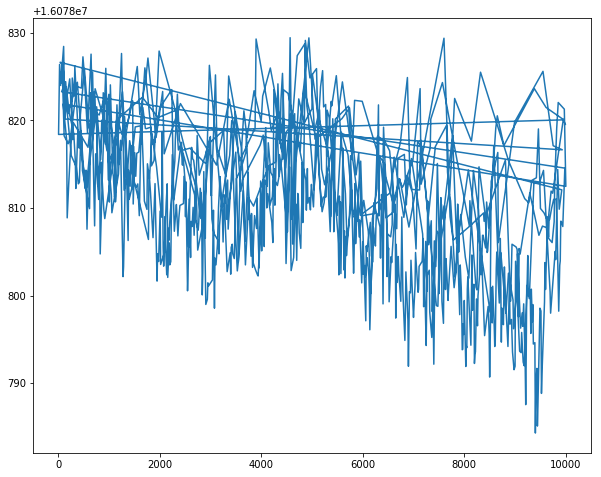

In [18]:
plt.plot(ene_temp[5,:,0], ene_temp[5,:,2])

Ugly, isn't it? The array is not ordered by iteration. The order can be seen here:

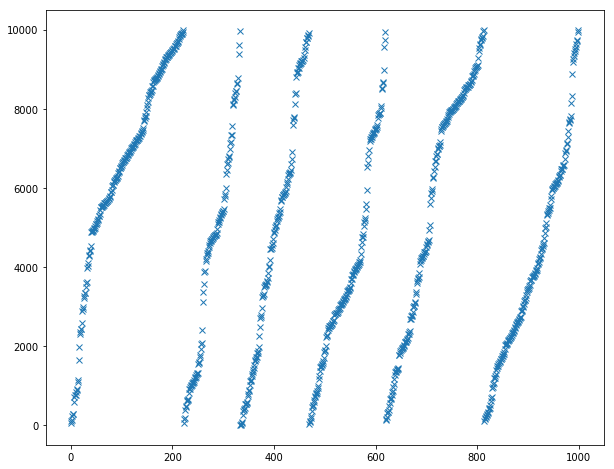

In [19]:
plt.plot(ene_temp[5,:,0],'x')

We have the structures at the correct temperature but still ordered from the 6 replicas that were running. Let's order them with respect to the first column. We cannot use sort here, because we want to use the order of the first column to order all the raw elements. We can get that order with `argsort` and then apply it to the array.

The problem is that the sizes of the sorting order do no agree with the sizes of `ene_temp`. To solve that we need to do a [trick](http://mail.scipy.org/pipermail/numpy-discussion/2009-February/040128.html) which I pesonally find very cumbersome. The reason is we need to broadcas correctly the dimensions of `order` into `ene_temp`. It's simplers to understand if you see that for the first temperatures we want:

    ene_temp[0, order[0]]
    ene_temp[1, order[1]]
    
and so on. It would seem that `ene_temp[:, order[:]]` but this performs the broadcasting in the wrong axis. Instead, we need to transpose the first axis, because what we are actually doing is:

    ene_temp[[0], order[0]]
    ene_temp[[1], order[1]]

And this can be done creating the vector `[[0], [1], [2]...` which is done with:  `np.arange(ene_temp.shape[0])[:, np.newaxis]`.


In [20]:
order = ene_temp[:, :, 0].argsort()
ene_temp = ene_temp[np.arange(ene_temp.shape[0])[:, np.newaxis], order]

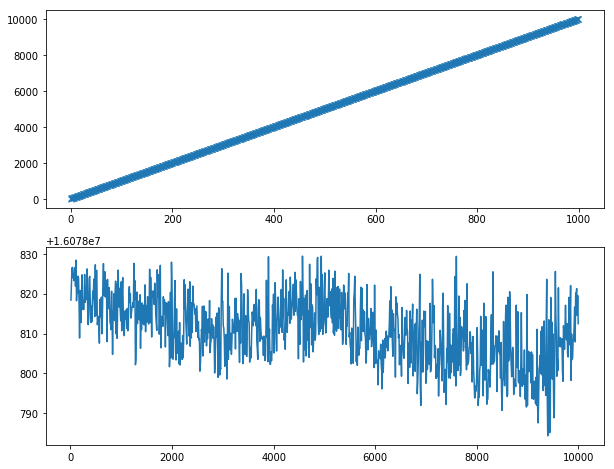

In [21]:
plt.subplot(2,1,1)
plt.plot(ene_temp[5,:,0],'x')
plt.subplot(2,1,2)
plt.plot(ene_temp[5,:,0], ene_temp[5,:,2])

Finally we can select and save the submatrix from iteration 2000 onwards:

In [22]:
np.save('energies_temperatures', ene_temp[ene_temp[:,:,0]>2000, :], )

## Advanced Topic: optimizing with numba

In the previous section, if there were $N$ temperatures we cycles the `all_enes` array $N$ times, which is not very efficient. We could potentially make if faster by running this in a single step. We create an empty arrray and fill it in with the correct values.

We first time our initial approach:

In [23]:
%%timeit
for ti in temperatures.astype(int):
    ene_temp[ti] = all_enes[all_enes[:,1]==ti, :]

1000 loops, best of 3: 791 µs per loop


Now we loop though all the rows and put each row to its corrrect first axis dimension. We need to keep an array of the filled positions.

In [25]:
ene_temp2 = np.zeros_like(ene_temp)
filled = np.zeros(len(temperatures), np.int)

for row in all_enes:
    ti = int(row[1])
    ene_temp2[ti, filled[ti]] = row
    filled[ti] +=1

We check we are still getting the same result, and we time it:

In [26]:
np.all(ene_temp2==ene_temp)

True

In [27]:
%%timeit
filled = np.zeros(len(temperatures), np.int)
for row in all_enes:
    ti = int(row[1])
    ene_temp2[ti, filled[ti]] = row
    filled[ti] +=1

100 loops, best of 3: 15.1 ms per loop


Good (ironically)! Two orders of magnitude slower than the first approach... The reason is that in the previous approach we were using numpy fast looping abilities, whereas now the loops are implemented in pure python and therefore are much slower.
This is the typical case where numba can increase the performance of such loops.

In [22]:
import numba

ImportError: No module named 'numba'

We first write a function of our lines. We avoid creating arrays into that function as those cannot be optimized with numba. We test our approach and check that the timings are the same.

In [84]:
def get_temperatures(array_in, array_out, filled):
    for r in range(array_in.shape[0]):
        ti = int(array_in[r,1])
        for j in range(array_in.shape[1]):
            array_out[ti, filled[ti], j] = array_in[r,j]
        filled[ti] +=1
    return array_out

In [86]:
%%timeit 
num_temp = len(temperatures)
m = all_enes.shape[0]
n = all_enes.shape[1]
m = m // num_temp
ene_temp = np.zeros((num_temp, m,n ))
filled = np.zeros(num_temp, np.int)
get_temperatures(all_enes, ene_temp, filled)

10 loops, best of 3: 76 ms per loop


Now we can pass this function to numba. The nopython option tell numba not to create object code which is as slow as python code. That is why we created the arrays outside the function. We also check the timings.

In [87]:
numba_get_temperatures = numba.jit(get_temperatures,nopython=True)

In [89]:
%%timeit 
num_temp = len(temperatures)
m = all_enes.shape[0]
n = all_enes.shape[1]
m = m // num_temp
ene_temp3 = np.zeros((num_temp, m,n ))
filled = np.zeros(num_temp, np.int)
numba_get_temperatures(all_enes, ene_temp3, filled)

1000 loops, best of 3: 326 µs per loop


Wow! Three orders of magnitude faster than the python and one order faster than our original numpy code (with only 6 temperatures!).

But having to declare all arrays outside is ugly. Is there a workaroud? Yes! Numba is clever enough to separate the loops from the array creation, and optimize the loops. This called [loop-lifting or loop-jitting](http://numba.pydata.org/numba-doc/0.17.0/glossary.html#term-loop-jitting). We need to remove the `nopython` option as part of the code will be object like, but we see that it is as efficient as before.

Here we also use a decoratior instead of a function call. The results are exactly the same, it just gives a shorter syntax.

In [75]:
@numba.jit 
def numba2_get_temperatures(array_in, num_temp):
    m = all_enes.shape[0]
    n = all_enes.shape[1]
    m = m // num_temp
    array_out = np.zeros((num_temp, m,n ))
    filled = np.zeros(num_temp, np.int)
    for r in range(array_in.shape[0]):
        ti = int(array_in[r,1])
        for j in range(array_in.shape[1]):
            array_out[ti, filled[ti], j] = array_in[r,j]
        filled[ti] +=1
    return array_out


In [90]:
%%timeit 
num_temp = len(temperatures)
ene_temp4 = numba2_get_temperatures(all_enes, num_temp)

1000 loops, best of 3: 327 µs per loop


In [91]:
np.all(numba2_get_temperatures(all_enes, num_temp)==ene_temp)

True